In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from theano_models import (Merge, Flatten, Reparameterize, reduce_all_identities,
                           inputting_references, outputting_references)
from theano_models.tools import (as_tensor_variable, total_size, clone, clone_all,
                                 squareplus, squareplus_inv, softplus, softplus_inv,
                                 square_01_R, square_01_R_inv, softmax, softmax_inv,
                                 PooledRandomStreams, get_profile)
from theano_models.util.theano_helpers import independent_subgraphs, list_random_sources
from theano_models.visualization import d3viz
from IPython.display import IFrame
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano_models.extra_models as em
import theano_models.postmaps as post
from theano_models.composing import normalizing_flow, variational_bayes

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
inputting_references.update(['to_be_randomized'])
inputting_references, outputting_references

({'flat',
  'inputs',
  'n_data',
  'noise',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'logP', 'loglikelihood', 'norm_det', 'outputs'})

# model

In [8]:
g1 = pm.Gauss(2)
g1

Gauss { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d5351b910 for function at 0x7f7d53526500>,
  'noise': [GaussianNoise.noise.0],
  'outputs': GaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [9]:
g2 = pm.Gauss(2)
g2

Gauss2 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d5351b980 for function at 0x7f7d534bc320>,
  'noise': [GaussianNoise2.noise.0],
  'outputs': GaussianNoise2.outputs,
  'parameters': [mean2],
  'parameters_positive': [var2]}

In [10]:
model = pm.Mixture(g1, g2)
model

Mixture { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d5351ba60 for function at 0x7f7d53526b90>,
  'noise': [GaussianNoise.noise.0, GaussianNoise2.noise.0],
  'outputs': Mixture.outputs,
  'parameters': [mean, mean2],
  'parameters_positive': [var, var2],
  'parameters_psumto1': [mixture_probs]}

In [11]:
model = Merge(model,
    Reparameterize(model['parameters_positive'], squareplus, squareplus_inv),
    Reparameterize(model['parameters_psumto1'], softmax, softmax_inv)
); model

Merge2 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d5351ba60 for function at 0x7f7d53526b90>,
  'noise': [GaussianNoise.noise.0, GaussianNoise2.noise.0],
  'outputs': Mixture.outputs,
  'parameters': [ mean,
                  mean2,
                  var_squareplus,
                  var2_squareplus,
                  mixture_probs_softmax],
  'parameters_positive': [],
  'parameters_psumto1': []}

In [12]:
model = Merge(model, Flatten(model['parameters']))
model

Merge3 { 'flat': "mean:mean2:var_squareplus:var2_squareplus:mixture_probs_softmax",
  'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d5351ba60 for function at 0x7f7d53526b90>,
  'noise': [GaussianNoise.noise.0, GaussianNoise2.noise.0],
  'outputs': Mixture.outputs,
  'parameters': [],
  'parameters_positive': [],
  'parameters_psumto1': []}

# Target

In [13]:
t1 = pm.Gauss(init_mean=[1,1], init_var=0.5)
t2 = pm.Gauss(init_mean=[0,4], init_var=0.1)
target = pm.Mixture(t1, t2, init_mixture_probs=[0.2, 0.8])
target

Mixture2 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d50074520 for function at 0x7f7d4ef84230>,
  'noise': [GaussianNoise3.noise.0, GaussianNoise4.noise.0],
  'outputs': Mixture2.outputs,
  'parameters': [mean3, mean4],
  'parameters_positive': [var3, var4],
  'parameters_psumto1': [mixture_probs]}

In [14]:
sampler = target.function()

In [15]:
training = np.array([sampler() for _ in range(5000)])
print training[:10]

validation = np.array([sampler() for _ in range(100)])
print validation[:10]

[[ 0.35645075  3.81399041]
 [ 0.08956851  4.27832917]
 [-0.02126824  4.11370434]
 [ 0.1661169   4.3827725 ]
 [-0.51666271  4.05684397]
 [-0.39733818  4.54977367]
 [-0.2051165   4.35764834]
 [-0.36951117  4.51934595]
 [-0.16463471  3.84729948]
 [ 0.31217509  4.17922744]]
[[-0.22844418  3.96372121]
 [ 2.34259127  1.25512251]
 [ 1.19787001  0.44361245]
 [-0.14752427  3.49685636]
 [ 1.24433436  1.22429619]
 [ 0.03497446  3.76639355]
 [ 0.10101704  3.84109248]
 [-0.06450553  4.2043025 ]
 [ 0.12390857  4.26343206]
 [-0.05471189  4.05867767]]


# Optimizer

In [16]:
postmap = compose(post.flat_numericalize_postmap, post.probabilistic_optimizer_postmap)
postmap_kwargs = {
    'mapreduce': summap,
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size, scale=0.01),
}

optimizer_kwargs = postmap(model, **postmap_kwargs)
climin_kwargs = post.climin_postmap(optimizer_kwargs)

In [17]:
batch_size = 200
n_batches = training.shape[0] // batch_size  # after this many steps we went through the whole data set once
climin_args = izip(
    imap(lambda a: (a,), chunk(batch_size, cycle(training))),  # args iterator (needs to return tuple!!)
    repeat({})  # kwargs iterator
)

In [18]:
opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **climin_kwargs
)

/home/stephan/GitProjects/breze/src/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


<IPython.core.display.Javascript object>


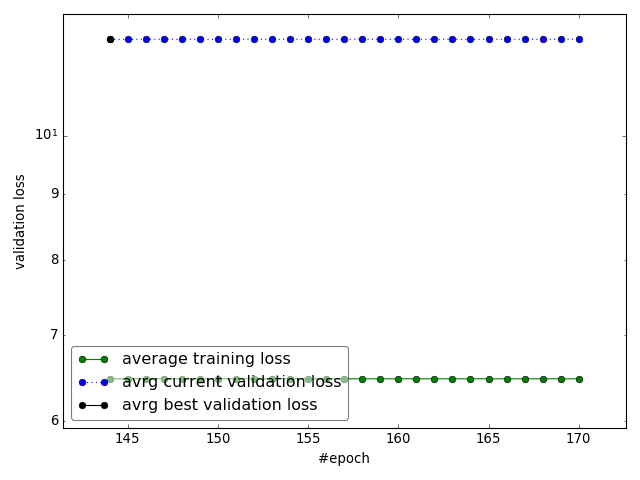

In [37]:
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
ylabel("validation loss")
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

In [38]:
best_val_loss = inf
best_wrt = None
val_size = 10 #batch_size

n_epochs = 100  # taken from UncertainWeightsPaper

for info in takeN(n_epochs, every(n_batches, opt)):
    current_epoch = info['n_iter']//n_batches
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, validation[:val_size]) #/val_size
    if val_loss < best_val_loss:
        best_wrt = opt.wrt
        best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)  
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    try:
        training_loss = info['loss'] #/ len(Z)  # TODO normalization needed?
    except KeyError:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, training[:val_size]) #/len(Z)
    add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

KeyboardInterrupt: 

In [32]:
f_parameters = theano.function([model['flat']], [g1.mean, t1.mean, g2.mean, t2.mean, g1.var, t1.var, g2.var, t2.var, model.mixture_probs, target.mixture_probs])
parameters = f_parameters(best_wrt)
print "%30s ~ target" % "fit"
for c in chunk_list(2, parameters):
    print "%30s ~ %s" % tuple(c)

                           fit ~ target
     [ 1.00611654  0.99720445] ~ [ 1.  1.]
     [ 0.00724363  3.98106564] ~ [ 0.  4.]
                0.548264462849 ~ 0.5
               0.0911917047276 ~ 0.1
     [ 0.21625114  0.78374886] ~ [ 0.2  0.8]
